# Analysis of the autism data

In [ ]:
run init.ipynb

In [110]:
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)



In [13]:
import os
import sys
import json 

from glob import glob
from tqdm import tqdm
from time import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.naive_bayes import GaussianNB

import prg

from xgboost import XGBClassifier, plot_importance, plot_tree
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

import torch
import shap



from sklearn.metrics import  (confusion_matrix, roc_curve, fbeta_score)


def find_optimal_threshold(y_true, y_pred):

    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))


    # Compute all the possible threshold
    _, _ , thresholds = roc_curve(y_true, y_pred)


    f1_c = []
    f2_c = []
    for th in thresholds[1:]:
        # For each threshold, compute the confusion matrix elements to be able to compute recall and precision 
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= th).ravel()    

        # Compute corrected precision (ppv)
        precision_corr = tp/(tp+correction_factor*fp)

        # Compute recall 
        recall =  tp / (tp+fn)

        f1_c.append(2*(precision_corr*recall)/(precision_corr+recall))

        beta = 2

        f2_c.append((1+beta**2)*(precision_corr*recall)/(beta**2 * precision_corr + recall))

    f2 = [fbeta_score(y_true, y_pred >= th, beta=2) for th in thresholds]
    best_f2, threshold_optimal_f2 = np.max(f2), thresholds[np.argmax(f2)-1]

    f1 = [fbeta_score(y_true, y_pred >= th, beta=1) for th in thresholds]
    best_f1, threshold_optimal_f1 = np.max(f2), thresholds[np.argmax(f1)-1]
    
    index_optimal_f1 = np.argmax(f1)-1
    index_optimal_f2 = np.argmax(f2)-1

    # Also return the f1c and f2c for the optimal f2 measure
    return best_f1, best_f2, f1_c[np.argmax(f2)-1], f2_c[np.argmax(f2)-1], index_optimal_f1, index_optimal_f2, threshold_optimal_f2

In [113]:
 deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All'])

['mean_gaze_percent_right',
 'gaze_silhouette_score',
 'FP_gaze_speech_correlation',
 'proportion_of_name_call_responses',
 'average_response_to_name_delay',
 'S_postural_sway',
 'NS_postural_sway',
 'S_postural_sway_derivative',
 'NS_postural_sway_derivative',
 'S_postural_sway_complexity',
 'NS_postural_sway_complexity',
 'S_blink_rate',
 'NS_blink_rate',
 'S_facing_forward',
 'NS_facing_forward',
 'S_eyebrows_complexity',
 'NS_eyebrows_complexity',
 'S_mouth_complexity',
 'NS_mouth_complexity',
 'pop_rate',
 'std_error',
 'average_length',
 'average_force_applied']

In [2]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)



exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=47)


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,FINAL,0.871,0.6,0.925,0.295,0.988,0.675,0.136,0.675,0.278,0.759,0.45,0.898,0.738,0.338,0.074,0.98,0.102,0.662,0.02,44,242,86,5


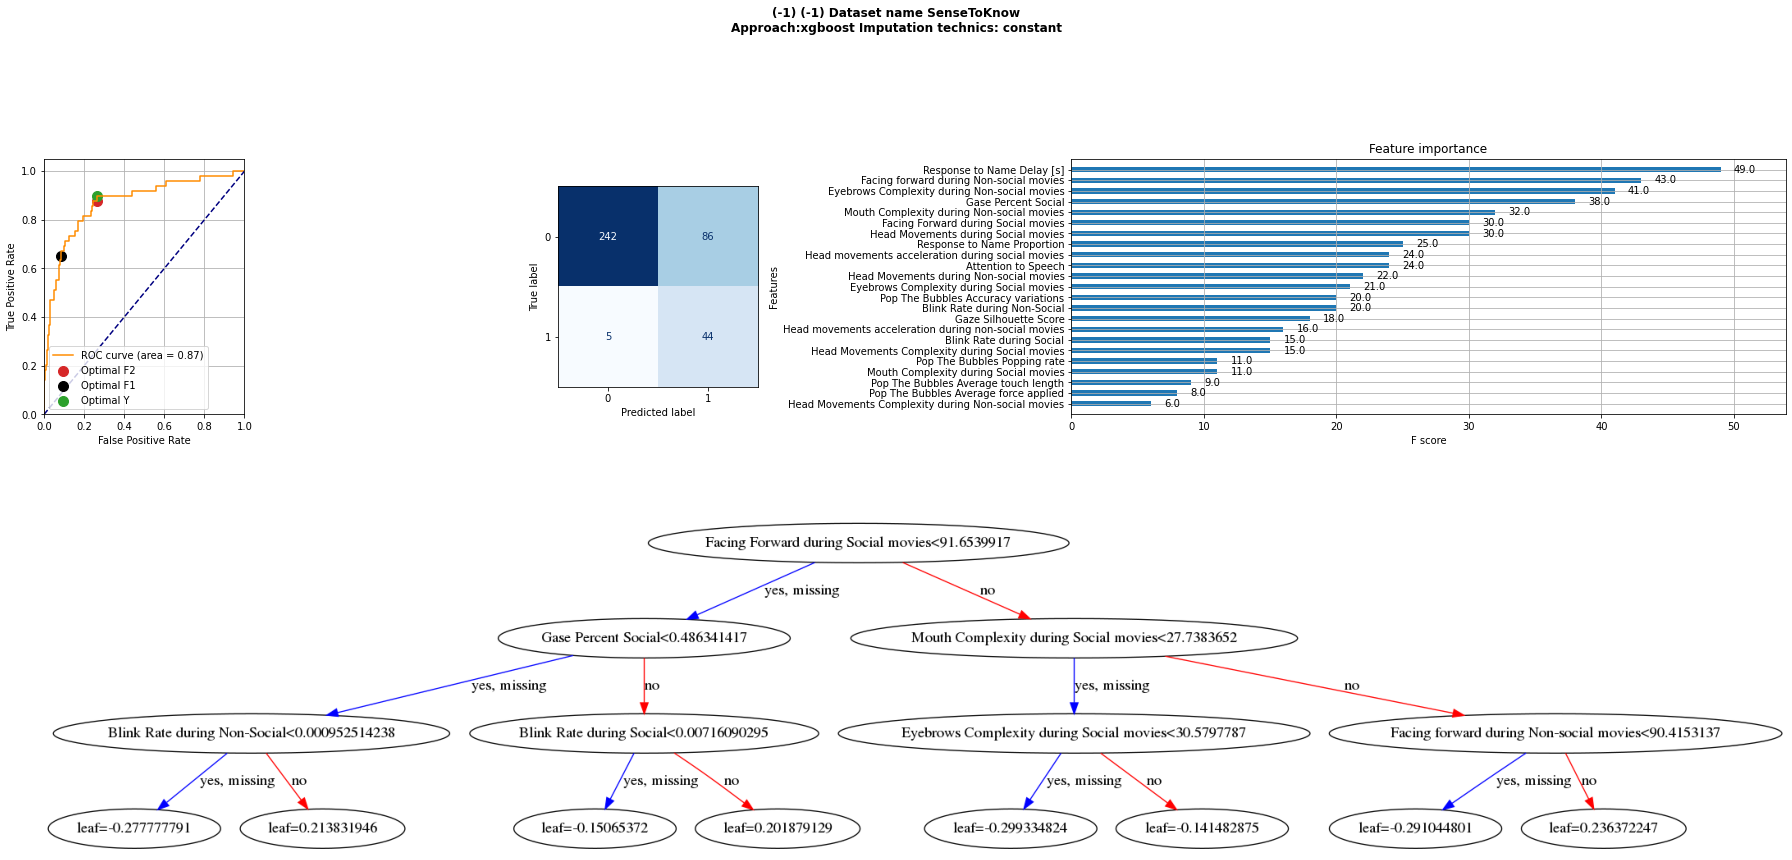

,Threshold index,Threshold,Sensitivity,Specificity,PPV,PPV_corr,NPV,NPV_corr
0,0,1.995613,0.000000,1.000000,NaN,NaN,0.870027,0.977273
1,1,0.995613,0.020408,1.000000,1.000000,1.000000,0.872340,0.977726
2,2,0.973665,0.142857,1.000000,1.000000,1.000000,0.886486,0.980456
3,3,0.952735,0.142857,0.993902,0.777778,0.352688,0.885870,0.980338
4,4,0.945759,0.183673,0.993902,0.818182,0.411945,0.890710,0.981257
...,...,...,...,...,...,...,...,...
59,59,0.000522,0.959184,0.222561,0.155629,0.027892,0.973333,0.995753
60,60,0.000510,0.979592,0.222561,0.158416,0.028469,0.986486,0.997872
61,61,0.000113,0.979592,0.054878,0.134078,0.023537,0.947368,0.991426
62,62,0.000113,1.000000,0.054878,0.136490,0.024015,1.000000,1.000000


In [3]:
exp.plot()

,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,FINAL,0.873,0.665,0.959,0.425,0.994,0.696,0.151,0.696,0.302,0.785,0.481,0.898,0.768,0.367,0.083,0.981,0.102,0.633,0.019,44,252,76,5


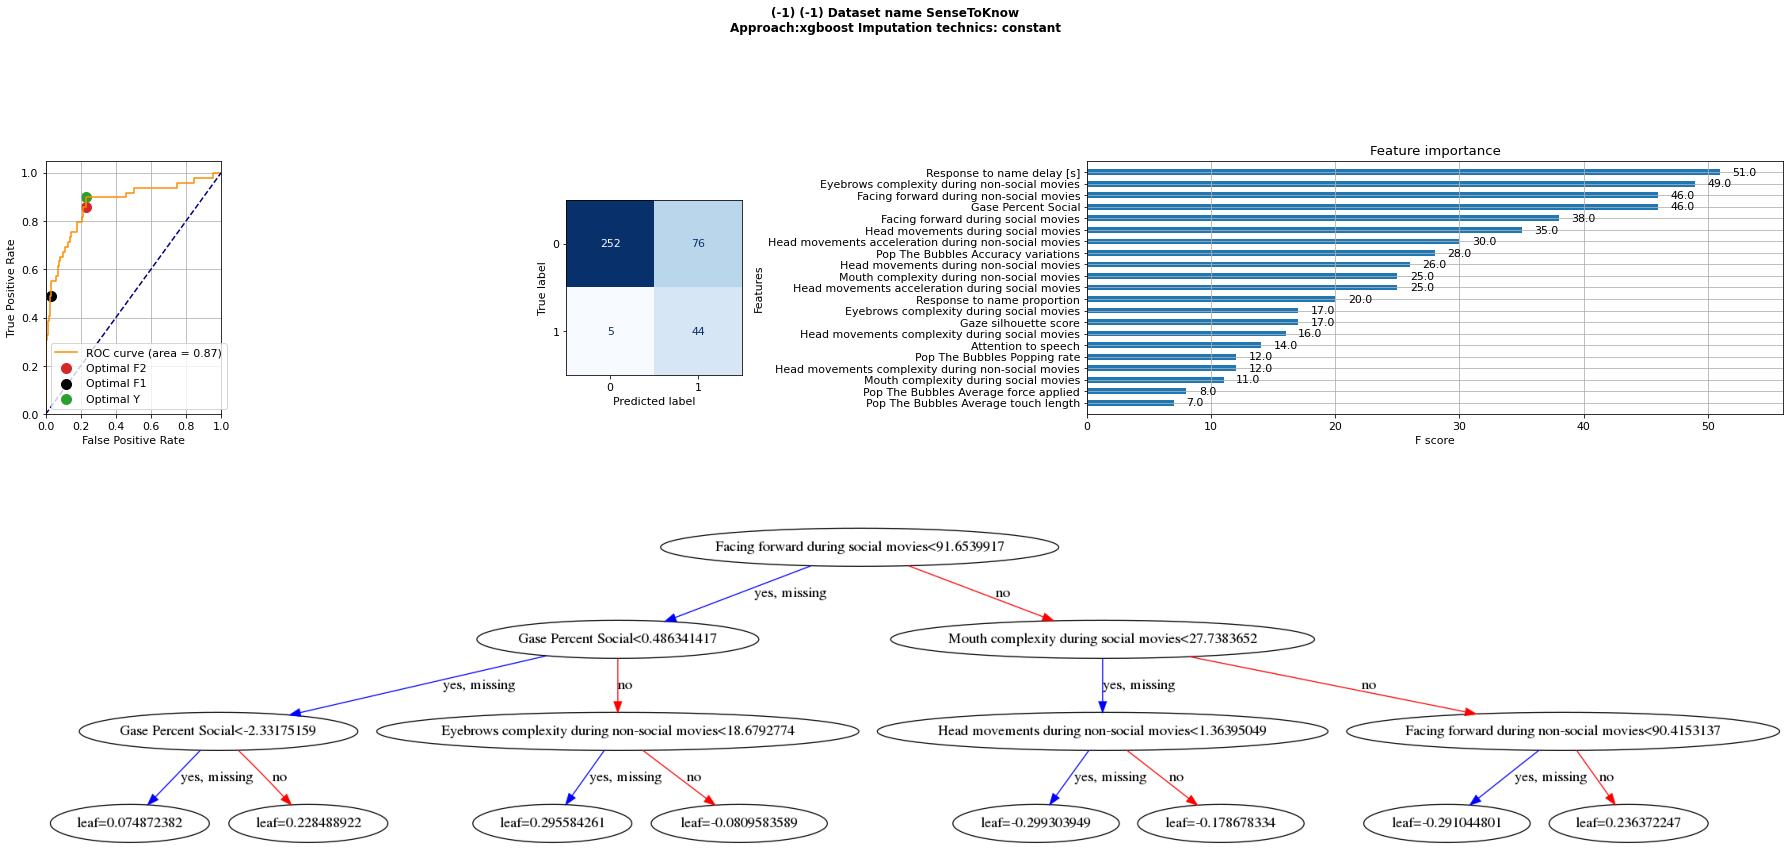

,Threshold index,Threshold,Sensitivity,Specificity,PPV,PPV_corr,NPV,NPV_corr
0,0,1.994025,0.000000,1.000000,NaN,NaN,0.870027,0.977273
1,1,0.994025,0.020408,1.000000,1.000000,1.000000,0.872340,0.977726
2,2,0.947152,0.285714,1.000000,1.000000,1.000000,0.903581,0.983660
3,3,0.939374,0.285714,0.996951,0.933333,0.685475,0.903315,0.983611
4,4,0.932120,0.306122,0.996951,0.937500,0.700157,0.905817,0.984072
...,...,...,...,...,...,...,...,...
52,52,0.000307,0.959184,0.152439,0.144615,0.025644,0.961538,0.993812
53,53,0.000305,0.979592,0.152439,0.147239,0.026175,0.980392,0.996896
54,54,0.000103,0.979592,0.048780,0.133333,0.023389,0.941176,0.990364
55,55,0.000098,1.000000,0.048780,0.135734,0.023865,1.000000,1.000000


In [47]:
exp.plot()

In [24]:
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
import prg


def _compute_performances_operating_points(self, y_true=None, y_pred=None):
    
    if y_true is None:
        
        # Build a function that display the Table S2 showing all performances for diffferent threshold or operating points) 

        y_true = self.predictions_df['y_true'].to_numpy()
        y_pred = self.predictions_df['y_pred'].to_numpy()


    # Compute all the possible threshold
    specificities_bar, sensitivities , thresholds = roc_curve(y_true, y_pred)

    specificities = 1 - specificities_bar


    # Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))

    ppv_list = []
    npv_list = []
    ppv_corr_list = []
    npv_corr_list = []

    for th in thresholds:

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= th).ravel()

        ppv = tp / (tp+fp)
        npv = tn / (tn+fn)

        # Compute corrected precision (ppv)
        ppv_corr = tp/(tp+correction_factor*fp)
        npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

        ppv_list.append(ppv)
        npv_list.append(npv)
        ppv_corr_list.append(ppv_corr)
        npv_corr_list.append(npv_corr)




    self.df_breakdown_results = pd.DataFrame({"Threshold index": np.arange(len(thresholds)), 
                                          "Threshold": thresholds, 
                                          "Sensitivity": sensitivities, 
                                          "Specificity": specificities, 
                                          "PPV": ppv_list, 
                                          "PPV_corr": ppv_corr_list, 
                                          "NPV": npv_list, 
                                          "NPV_corr": npv_corr_list, 
                                         })
    
    return 

In [38]:
def find_optimal_threshold_youden(y_true, y_pred):
    
    # Compute the performances using Younden Index


    y_true = exp.predictions_df['y_true'].to_numpy()
    y_pred = exp.predictions_df['y_pred'].to_numpy()


    # Compute all the possible threshold
    specificities_bar, sensitivities , thresholds = roc_curve(y_true, y_pred)

    specificities = 1 - specificities_bar

    younden_indexes = sensitivities + specificities - 1

    max_youden, index_threshold = np.max(younden_indexes),  np.argmax(younden_indexes)
    
    optimal_threshold = thresholds[index_threshold]
    
    
    return max_youden, index_threshold, optimal_threshold





# Compute imbalance_ratio of our sample
pi = y_true.mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))

ppv_list = []
npv_list = []
ppv_corr_list = []
npv_corr_list = []

thresholds = [thresholds[index_threshold]]

for th in thresholds:

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= th).ravel()

    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)

    # Compute corrected precision (ppv)
    ppv_corr = tp/(tp+correction_factor*fp)
    npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

    ppv_list.append(ppv)
    npv_list.append(npv)
    ppv_corr_list.append(ppv_corr)
    npv_corr_list.append(npv_corr)




df_breakdown_results = pd.DataFrame({"Sensitivity": sensitivities[index_threshold],
                                     "Specificity": specificities[index_threshold],
                                      "PPV": ppv_list, 
                                      "PPV_corr": ppv_corr_list, 
                                      "NPV": npv_list, 
                                      "NPV_corr": npv_corr_list, 
                                     })

df_breakdown_results

,Sensitivity,Specificity,PPV,PPV_corr,NPV,NPV_corr
0,0.897959,0.768293,0.366667,0.082675,0.980545,0.996921


In [39]:
max_youden

0.6662518666002986

In [40]:
0.897959 + 0.768293 -1

0.6662520000000001

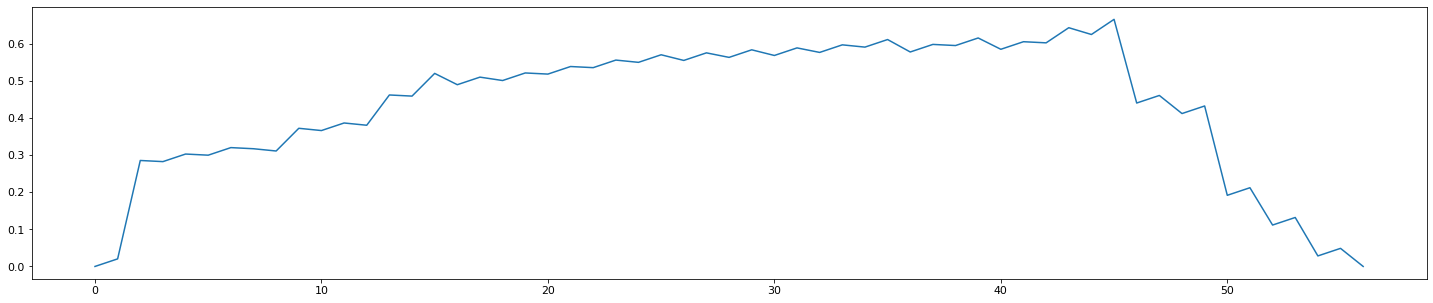

In [32]:
fi(25, 5)
plt.plot(younden_indexes)

In [41]:
# Compute first AUROC
auroc = roc_auc_score(y_true, y_pred)
auroc

0.8730711796913887

In [ ]:
 df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='15_December_Final_Importance_Computation', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=10, sample_weight=None, random_state=random_state)
    display(exp.performances_df)
    

In [2]:
def compute_SD(AUC, N1, N2):
    """
            In the original paper of 1982, N1 is the number of "abnormal images", therefore here it is supposed to translate as the number of cases in the positive class.
    """
    Q1=AUC/(2-AUC)
    Q2 = 2*AUC*AUC/(1+AUC)
    return(np.sqrt((AUC*(1-AUC)+(N1-1)*(Q1-AUC*AUC) + (N2-1)*(Q2-AUC*AUC))/(N1*N2)))

compute_SD(0.907, 123, 15498)

0.018073483823852675

In [ ]:
def correct_PPV_NPV(TN, FN, TP, FP, pi_study, pi_pop=REFERENCE_IMBALANCE_RATIO)

# Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-pi_pop))/(pi_pop*(1-pi))

    # Compute corrected precision (ppv)
    ppv_corr = TP/(TP+correction_factor*FP)
    
    npv_corr = (correction_factor*TN)/(correction_factor*TN+FN)
    
    return ppv_corr, npv_corr





# Analysis of the autism data

In [ ]:
run init.ipynb

In [110]:
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)



In [13]:
import os
import sys
import json 

from glob import glob
from tqdm import tqdm
from time import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.naive_bayes import GaussianNB

import prg

from xgboost import XGBClassifier, plot_importance, plot_tree
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

import torch
import shap



from sklearn.metrics import  (confusion_matrix, roc_curve, fbeta_score)


def find_optimal_threshold(y_true, y_pred):

    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))


    # Compute all the possible threshold
    _, _ , thresholds = roc_curve(y_true, y_pred)


    f1_c = []
    f2_c = []
    for th in thresholds[1:]:
        # For each threshold, compute the confusion matrix elements to be able to compute recall and precision 
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= th).ravel()    

        # Compute corrected precision (ppv)
        precision_corr = tp/(tp+correction_factor*fp)

        # Compute recall 
        recall =  tp / (tp+fn)

        f1_c.append(2*(precision_corr*recall)/(precision_corr+recall))

        beta = 2

        f2_c.append((1+beta**2)*(precision_corr*recall)/(beta**2 * precision_corr + recall))

    f2 = [fbeta_score(y_true, y_pred >= th, beta=2) for th in thresholds]
    best_f2, threshold_optimal_f2 = np.max(f2), thresholds[np.argmax(f2)-1]

    f1 = [fbeta_score(y_true, y_pred >= th, beta=1) for th in thresholds]
    best_f1, threshold_optimal_f1 = np.max(f2), thresholds[np.argmax(f1)-1]
    
    index_optimal_f1 = np.argmax(f1)-1
    index_optimal_f2 = np.argmax(f2)-1

    # Also return the f1c and f2c for the optimal f2 measure
    return best_f1, best_f2, f1_c[np.argmax(f2)-1], f2_c[np.argmax(f2)-1], index_optimal_f1, index_optimal_f2, threshold_optimal_f2

In [113]:
 deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All'])

['mean_gaze_percent_right',
 'gaze_silhouette_score',
 'FP_gaze_speech_correlation',
 'proportion_of_name_call_responses',
 'average_response_to_name_delay',
 'S_postural_sway',
 'NS_postural_sway',
 'S_postural_sway_derivative',
 'NS_postural_sway_derivative',
 'S_postural_sway_complexity',
 'NS_postural_sway_complexity',
 'S_blink_rate',
 'NS_blink_rate',
 'S_facing_forward',
 'NS_facing_forward',
 'S_eyebrows_complexity',
 'NS_eyebrows_complexity',
 'S_mouth_complexity',
 'NS_mouth_complexity',
 'pop_rate',
 'std_error',
 'average_length',
 'average_force_applied']

In [2]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)



exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=47)


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,FINAL,0.871,0.6,0.925,0.295,0.988,0.675,0.136,0.675,0.278,0.759,0.45,0.898,0.738,0.338,0.074,0.98,0.102,0.662,0.02,44,242,86,5


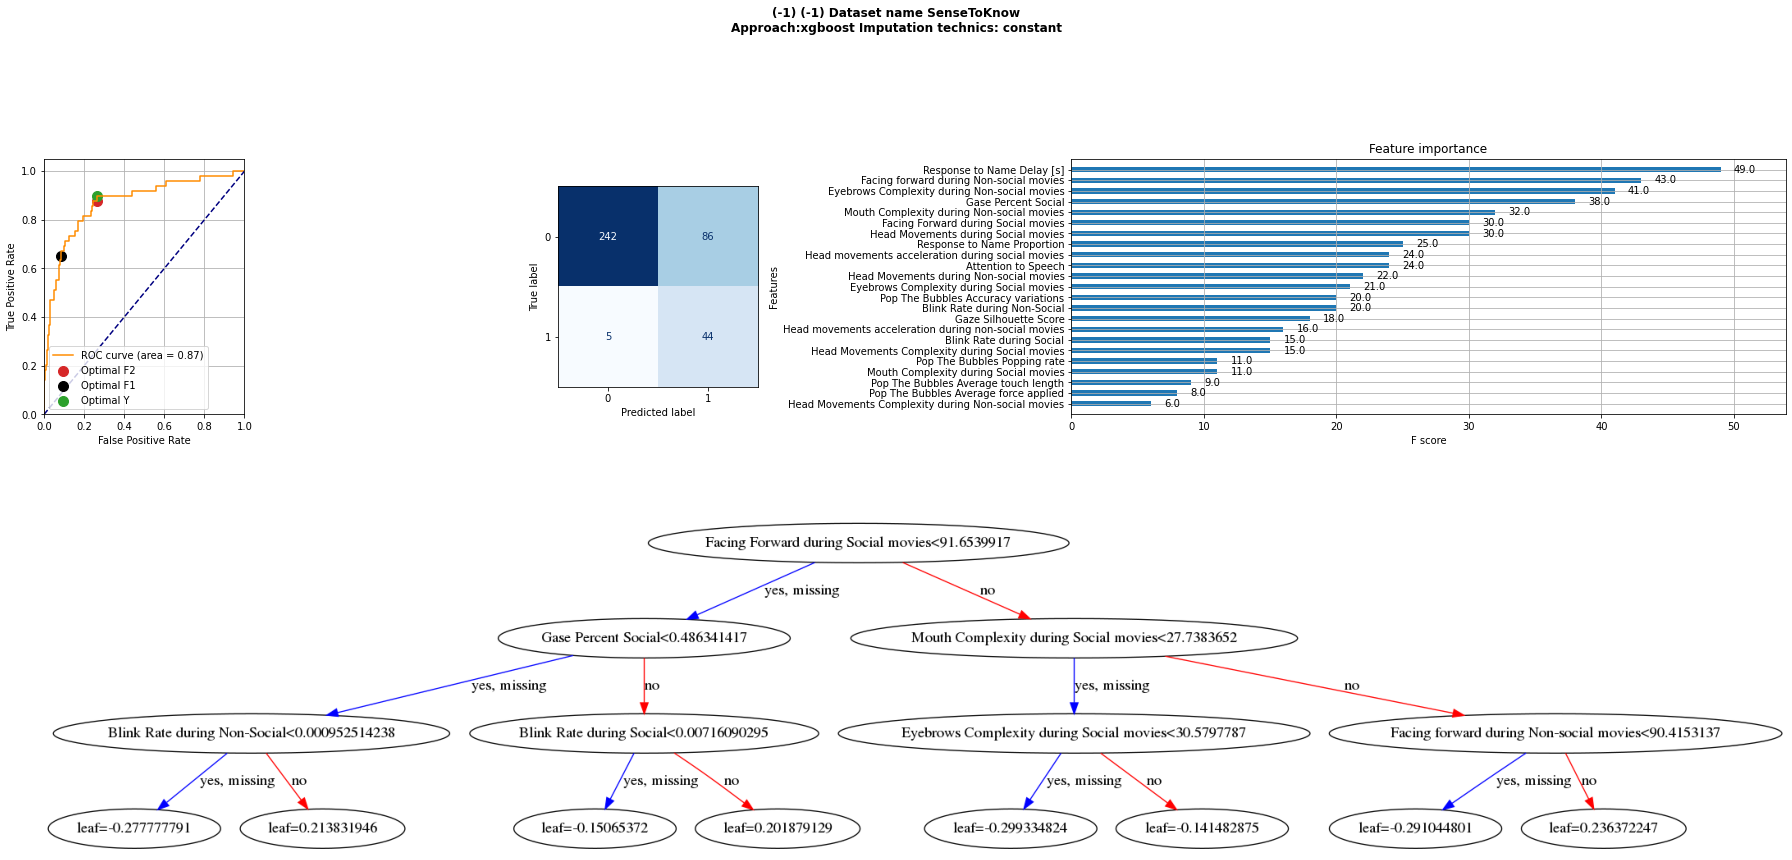

,Threshold index,Threshold,Sensitivity,Specificity,PPV,PPV_corr,NPV,NPV_corr
0,0,1.995613,0.000000,1.000000,NaN,NaN,0.870027,0.977273
1,1,0.995613,0.020408,1.000000,1.000000,1.000000,0.872340,0.977726
2,2,0.973665,0.142857,1.000000,1.000000,1.000000,0.886486,0.980456
3,3,0.952735,0.142857,0.993902,0.777778,0.352688,0.885870,0.980338
4,4,0.945759,0.183673,0.993902,0.818182,0.411945,0.890710,0.981257
...,...,...,...,...,...,...,...,...
59,59,0.000522,0.959184,0.222561,0.155629,0.027892,0.973333,0.995753
60,60,0.000510,0.979592,0.222561,0.158416,0.028469,0.986486,0.997872
61,61,0.000113,0.979592,0.054878,0.134078,0.023537,0.947368,0.991426
62,62,0.000113,1.000000,0.054878,0.136490,0.024015,1.000000,1.000000


In [3]:
exp.plot()

,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,FINAL,0.873,0.665,0.959,0.425,0.994,0.696,0.151,0.696,0.302,0.785,0.481,0.898,0.768,0.367,0.083,0.981,0.102,0.633,0.019,44,252,76,5


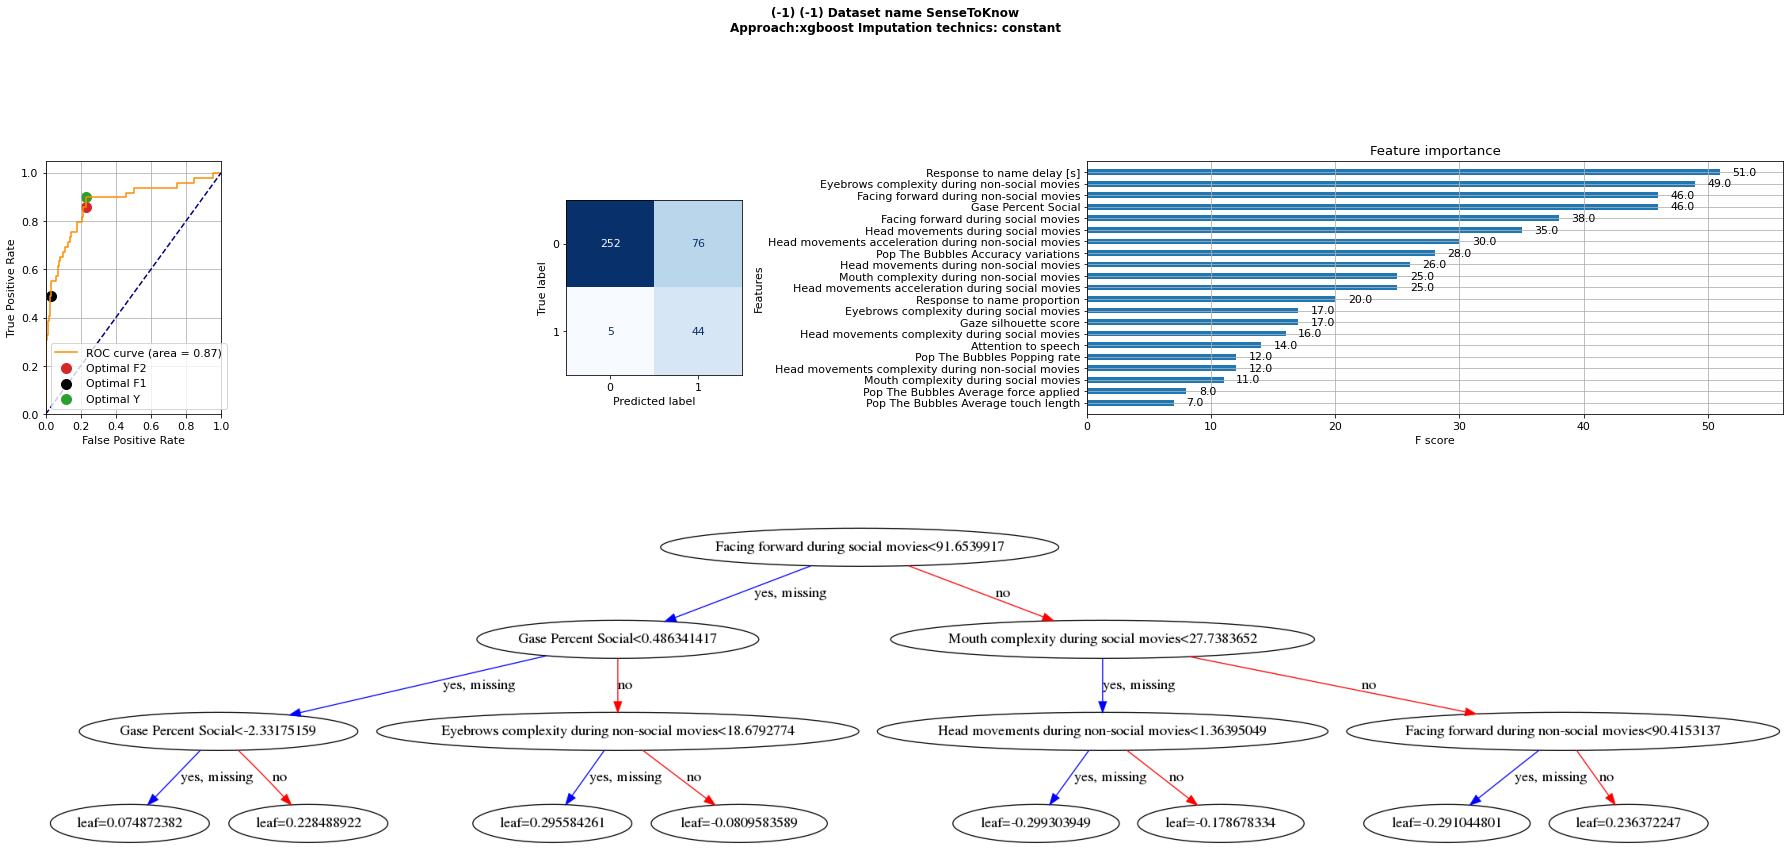

,Threshold index,Threshold,Sensitivity,Specificity,PPV,PPV_corr,NPV,NPV_corr
0,0,1.994025,0.000000,1.000000,NaN,NaN,0.870027,0.977273
1,1,0.994025,0.020408,1.000000,1.000000,1.000000,0.872340,0.977726
2,2,0.947152,0.285714,1.000000,1.000000,1.000000,0.903581,0.983660
3,3,0.939374,0.285714,0.996951,0.933333,0.685475,0.903315,0.983611
4,4,0.932120,0.306122,0.996951,0.937500,0.700157,0.905817,0.984072
...,...,...,...,...,...,...,...,...
52,52,0.000307,0.959184,0.152439,0.144615,0.025644,0.961538,0.993812
53,53,0.000305,0.979592,0.152439,0.147239,0.026175,0.980392,0.996896
54,54,0.000103,0.979592,0.048780,0.133333,0.023389,0.941176,0.990364
55,55,0.000098,1.000000,0.048780,0.135734,0.023865,1.000000,1.000000


In [47]:
exp.plot()

In [24]:
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
import prg


def _compute_performances_operating_points(self, y_true=None, y_pred=None):
    
    if y_true is None:
        
        # Build a function that display the Table S2 showing all performances for diffferent threshold or operating points) 

        y_true = self.predictions_df['y_true'].to_numpy()
        y_pred = self.predictions_df['y_pred'].to_numpy()


    # Compute all the possible threshold
    specificities_bar, sensitivities , thresholds = roc_curve(y_true, y_pred)

    specificities = 1 - specificities_bar


    # Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))

    ppv_list = []
    npv_list = []
    ppv_corr_list = []
    npv_corr_list = []

    for th in thresholds:

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= th).ravel()

        ppv = tp / (tp+fp)
        npv = tn / (tn+fn)

        # Compute corrected precision (ppv)
        ppv_corr = tp/(tp+correction_factor*fp)
        npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

        ppv_list.append(ppv)
        npv_list.append(npv)
        ppv_corr_list.append(ppv_corr)
        npv_corr_list.append(npv_corr)




    self.df_breakdown_results = pd.DataFrame({"Threshold index": np.arange(len(thresholds)), 
                                          "Threshold": thresholds, 
                                          "Sensitivity": sensitivities, 
                                          "Specificity": specificities, 
                                          "PPV": ppv_list, 
                                          "PPV_corr": ppv_corr_list, 
                                          "NPV": npv_list, 
                                          "NPV_corr": npv_corr_list, 
                                         })
    
    return 

In [38]:
def find_optimal_threshold_youden(y_true, y_pred):
    
    # Compute the performances using Younden Index


    y_true = exp.predictions_df['y_true'].to_numpy()
    y_pred = exp.predictions_df['y_pred'].to_numpy()


    # Compute all the possible threshold
    specificities_bar, sensitivities , thresholds = roc_curve(y_true, y_pred)

    specificities = 1 - specificities_bar

    younden_indexes = sensitivities + specificities - 1

    max_youden, index_threshold = np.max(younden_indexes),  np.argmax(younden_indexes)
    
    optimal_threshold = thresholds[index_threshold]
    
    
    return max_youden, index_threshold, optimal_threshold





# Compute imbalance_ratio of our sample
pi = y_true.mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))

ppv_list = []
npv_list = []
ppv_corr_list = []
npv_corr_list = []

thresholds = [thresholds[index_threshold]]

for th in thresholds:

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= th).ravel()

    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)

    # Compute corrected precision (ppv)
    ppv_corr = tp/(tp+correction_factor*fp)
    npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

    ppv_list.append(ppv)
    npv_list.append(npv)
    ppv_corr_list.append(ppv_corr)
    npv_corr_list.append(npv_corr)




df_breakdown_results = pd.DataFrame({"Sensitivity": sensitivities[index_threshold],
                                     "Specificity": specificities[index_threshold],
                                      "PPV": ppv_list, 
                                      "PPV_corr": ppv_corr_list, 
                                      "NPV": npv_list, 
                                      "NPV_corr": npv_corr_list, 
                                     })

df_breakdown_results

,Sensitivity,Specificity,PPV,PPV_corr,NPV,NPV_corr
0,0.897959,0.768293,0.366667,0.082675,0.980545,0.996921


In [39]:
max_youden

0.6662518666002986

In [40]:
0.897959 + 0.768293 -1

0.6662520000000001

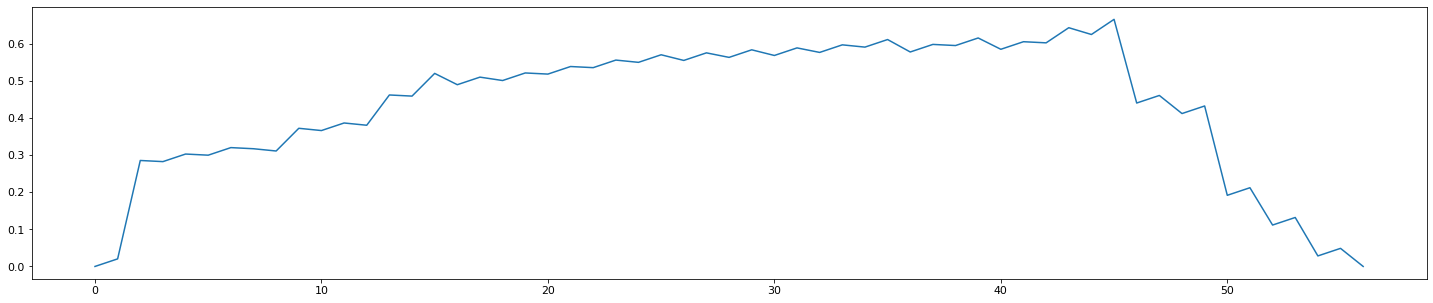

In [32]:
fi(25, 5)
plt.plot(younden_indexes)

In [41]:
# Compute first AUROC
auroc = roc_auc_score(y_true, y_pred)
auroc

0.8730711796913887

In [ ]:
 df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='15_December_Final_Importance_Computation', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=10, sample_weight=None, random_state=random_state)
    display(exp.performances_df)
    

In [2]:
def compute_SD(AUC, N1, N2):
    """
            In the original paper of 1982, N1 is the number of "abnormal images", therefore here it is supposed to translate as the number of cases in the positive class.
    """
    Q1=AUC/(2-AUC)
    Q2 = 2*AUC*AUC/(1+AUC)
    return(np.sqrt((AUC*(1-AUC)+(N1-1)*(Q1-AUC*AUC) + (N2-1)*(Q2-AUC*AUC))/(N1*N2)))

compute_SD(0.907, 123, 15498)

0.018073483823852675

In [ ]:
def correct_PPV_NPV(TN, FN, TP, FP, pi_study, pi_pop=REFERENCE_IMBALANCE_RATIO)

# Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-pi_pop))/(pi_pop*(1-pi))

    # Compute corrected precision (ppv)
    ppv_corr = TP/(TP+correction_factor*FP)
    
    npv_corr = (correction_factor*TN)/(correction_factor*TN+FN)
    
    return ppv_corr, npv_corr



